Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to BVP
R device_subscribe bvp OK

Resuming data receiving
R pause OFF

Streaming...


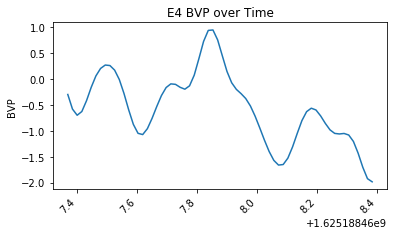

Disconnecting from device


In [4]:
import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# SELECT DATA TO STREAM
acc = False      # 3-axis acceleration
bvp = True      # Blood Volume Pulse
gsr = False      # Galvanic Skin Response (Electrodermal Activity)
tmp = False       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    stream()

global bvp_timestamp
bvp_timestamp = []
global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []

global fig
fig = plt.figure()
global ax
ax = fig.add_subplot(1, 1, 1)

def animate(i, xs, ys):

    # Read temperature (Celsius) from TMP102
    #temp_c = round(tmp102.read_temp(), 2)
    # NEEDS UPDATE HERE!

    # Add x and y to lists
    #xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
    #ys.append(temp_c) 

    # Limit x and y lists to 20 items
    xs = xs[-1000:]
    ys = ys[-1000:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('E4 BVP over Time')
    plt.ylabel('BVP') 


def stream():
    try:
        print("Streaming...")
        while True:
            try:
                response = s.recv(bufferSize).decode("utf-8")
                #print(response)
                if "connection lost to device" in response:
                    print(response.decode("utf-8"))
                    reconnect()
                    break
                samples = response.split("\n")
                for i in range(len(samples)-1):
                    stream_type = samples[i].split()[0]
                    """ if stream_type == "E4_Acc":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
                        outletACC.push_sample(data, timestamp=timestamp) """
                    if stream_type == "E4_Bvp":
                        bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        bvp_new_data = float(samples[i].split()[2].replace(',','.'))
                        bvp_timestamp.append(bvp_new_timestamp)
                        bvp_data.append(bvp_new_data)                        
                    """ if stream_type == "E4_Gsr":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletGSR.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Temperature":
                        temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        temp_new_data = float(samples[i].split()[2].replace(',','.'))
                        temp_timestamp.append(temp_new_timestamp)
                        temp_data.append(temp_new_data) """
                    """ if stream_type == "E4_Ibi":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletIBI.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Tag":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTag.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Battery":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletBatt.push_sample([data], timestamp=timestamp) """
                    # Create figure for plotting
                    """ fig = plt.figure()
                    ax = fig.add_subplot(1, 1, 1) 
                    xs = []
                    ys = [] 

                    # Initialize communication with TMP102
                    #tmp102.init()

                    # This function is called periodically from FuncAnimation
                    def animate(i, xs, ys):

                    # Read temperature (Celsius) from TMP102
                    #temp_c = round(tmp102.read_temp(), 2)
                    # NEEDS UPDATE HERE!

                    # Add x and y to lists
                    xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
                    #ys.append(temp_c) 

                    # Limit x and y lists to 20 items
                    xs = xs[-1000:]
                    ys = ys[-1000:]

                    # Draw x and y lists
                    ax.clear()
                    ax.plot(xs, ys)

                    # Format plot
                    plt.xticks(rotation=45, ha='right')
                    plt.subplots_adjust(bottom=0.30)
                    plt.title('E4 BVP over Time')
                    plt.ylabel('BVP') """
                # Set up plot to call animate() function periodically
                ani = animation.FuncAnimation(fig, animate, fargs=(bvp_timestamp, bvp_data), interval=1000)
                plt.show()

                
                #time.sleep(1)
            except socket.timeout:
                print("Socket timeout")
                reconnect()
                break
    except KeyboardInterrupt:
        print("Disconnecting from device")
        s.send("device_disconnect\r\n".encode())
        s.close()
stream()

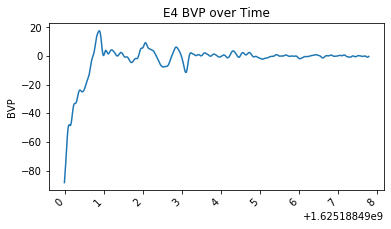

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def animate(i, xs, ys):

    # Read temperature (Celsius) from TMP102
    #temp_c = round(tmp102.read_temp(), 2)
    # NEEDS UPDATE HERE!

    # Add x and y to lists
    """ xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
    ys.append(temp_c) """

    # Limit x and y lists to 20 items
    xs = xs[-500:]
    ys = ys[-500:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('E4 BVP over Time')
    plt.ylabel('BVP')

ani = animation.FuncAnimation(fig, animate, fargs=(bvp_timestamp, bvp_data), interval=1000)
plt.show()

In [20]:
max(bvp_data)
min(bvp_data)

-4.254272

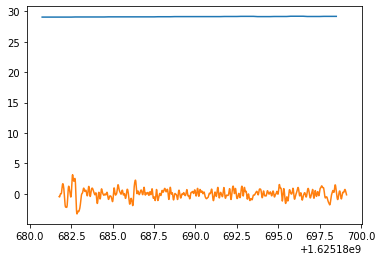

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(temp_timestamp, temp_data)
plt.plot(bvp_timestamp, bvp_data)


Text(0.5, 1.0, 'BVP')

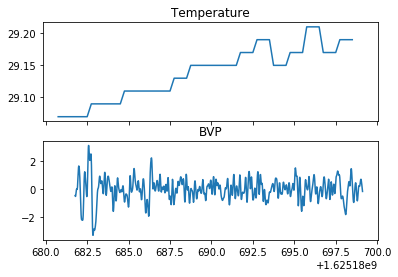

In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(temp_timestamp, temp_data)
axs[0].set_title("Temperature")
axs[1].plot(bvp_timestamp, bvp_data)
axs[1].set_title("BVP")

In [4]:
test = []
test

[]

In [11]:
test.append(0.9)

In [12]:
test

[0.9, 0.9, 0.9, 0.9, 0.9, 0.9]

In [ ]:
outletTemp

In [ ]:
1+1

2

In [13]:
## Attempting to Recieve and Plot the data while being streamed
## Not currently working on Anthony's pc because of PyQt.  To be investigated further, or a different real-time plotting package will be used

import numpy as np
import math
import pylsl
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
from typing import List

# Basic parameters for the plotting window
plot_duration = 5  # how many seconds of data to show
update_interval = 60  # ms between screen updates
pull_interval = 500  # ms between each pull operation


class Inlet:
    """Base class to represent a plottable inlet"""
    def __init__(self, info: pylsl.StreamInfo):
        # create an inlet and connect it to the outlet we found earlier.
        # max_buflen is set so data older the plot_duration is discarded
        # automatically and we only pull data new enough to show it

        # Also, perform online clock synchronization so all streams are in the
        # same time domain as the local lsl_clock()
        # (see https://labstreaminglayer.readthedocs.io/projects/liblsl/ref/enums.html#_CPPv414proc_clocksync)
        # and dejitter timestamps
        self.inlet = pylsl.StreamInlet(info, max_buflen=plot_duration,
                                       processing_flags=pylsl.proc_clocksync | pylsl.proc_dejitter)
        # store the name and channel count
        self.name = info.name()
        self.channel_count = info.channel_count()

    def pull_and_plot(self, plot_time: float, plt: pg.PlotItem):
        """Pull data from the inlet and add it to the plot.
        :param plot_time: lowest timestamp that's still visible in the plot
        :param plt: the plot the data should be shown on
        """
        # We don't know what to do with a generic inlet, so we skip it.
        pass


class DataInlet(Inlet):
    """A DataInlet represents an inlet with continuous, multi-channel data that
    should be plotted as multiple lines."""
    dtypes = [[], np.float32, np.float64, None, np.int32, np.int16, np.int8, np.int64]

    def __init__(self, info: pylsl.StreamInfo, plt: pg.PlotItem):
        super().__init__(info)
        # calculate the size for our buffer, i.e. two times the displayed data
        bufsize = (2 * math.ceil(info.nominal_srate() * plot_duration), info.channel_count())
        self.buffer = np.empty(bufsize, dtype=self.dtypes[info.channel_format()])
        empty = np.array([])
        # create one curve object for each channel/line that will handle displaying the data
        self.curves = [pg.PlotCurveItem(x=empty, y=empty, autoDownsample=True) for _ in range(self.channel_count)]
        for curve in self.curves:
            plt.addItem(curve)

    def pull_and_plot(self, plot_time, plt):
        # pull the data
        _, ts = self.inlet.pull_chunk(timeout=0.0,
                                      max_samples=self.buffer.shape[0],
                                      dest_obj=self.buffer)
        # ts will be empty if no samples were pulled, a list of timestamps otherwise
        if ts:
            ts = np.asarray(ts)
            y = self.buffer[0:ts.size, :]
            this_x = None
            old_offset = 0
            new_offset = 0
            for ch_ix in range(self.channel_count):
                # we don't pull an entire screen's worth of data, so we have to
                # trim the old data and append the new data to it
                old_x, old_y = self.curves[ch_ix].getData()
                # the timestamps are identical for all channels, so we need to do
                # this calculation only once
                if ch_ix == 0:
                    # find the index of the first sample that's still visible,
                    # i.e. newer than the left border of the plot
                    old_offset = old_x.searchsorted(plot_time)
                    # same for the new data, in case we pulled more data than
                    # can be shown at once
                    new_offset = ts.searchsorted(plot_time)
                    # append new timestamps to the trimmed old timestamps
                    this_x = np.hstack((old_x[old_offset:], ts[new_offset:]))
                # append new data to the trimmed old data
                this_y = np.hstack((old_y[old_offset:], y[new_offset:, ch_ix] - ch_ix))
                # replace the old data
                self.curves[ch_ix].setData(this_x, this_y)


class MarkerInlet(Inlet):
    """A MarkerInlet shows events that happen sporadically as vertical lines"""
    def __init__(self, info: pylsl.StreamInfo):
        super().__init__(info)

    def pull_and_plot(self, plot_time, plt):
        # TODO: purge old markers
        strings, timestamps = self.inlet.pull_chunk(0)
        if timestamps:
            for string, ts in zip(strings, timestamps):
                plt.addItem(pg.InfiniteLine(ts, angle=90, movable=False, label=string[0]))


def main():
    # firstly resolve all streams that could be shown
    inlets: List[Inlet] = []
    print("looking for streams")
    streams = pylsl.resolve_streams()

    # Create the pyqtgraph window
    pw = pg.plot(title='LSL Plot')
    plt = pw.getPlotItem()
    plt.enableAutoRange(x=False, y=True)

    # iterate over found streams, creating specialized inlet objects that will
    # handle plotting the data
    for info in streams:
        if info.type() == 'Markers':
            if info.nominal_srate() != pylsl.IRREGULAR_RATE \
                    or info.channel_format() != pylsl.cf_string:
                print('Invalid marker stream ' + info.name())
            print('Adding marker inlet: ' + info.name())
            inlets.append(MarkerInlet(info))
        elif info.nominal_srate() != pylsl.IRREGULAR_RATE \
                and info.channel_format() != pylsl.cf_string:
            print('Adding data inlet: ' + info.name())
            inlets.append(DataInlet(info, plt))
        else:
            print('Don\'t know what to do with stream ' + info.name())

    def scroll():
        """Move the view so the data appears to scroll"""
        # We show data only up to a timepoint shortly before the current time
        # so new data doesn't suddenly appear in the middle of the plot
        fudge_factor = pull_interval * .002
        plot_time = pylsl.local_clock()
        pw.setXRange(plot_time - plot_duration + fudge_factor, plot_time - fudge_factor)

    def update():
        # Read data from the inlet. Use a timeout of 0.0 so we don't block GUI interaction.
        mintime = pylsl.local_clock() - plot_duration
        # call pull_and_plot for each inlet.
        # Special handling of inlet types (markers, continuous data) is done in
        # the different inlet classes.
        for inlet in inlets:
            inlet.pull_and_plot(mintime, plt)

    # create a timer that will move the view every update_interval ms
    update_timer = QtCore.QTimer()
    update_timer.timeout.connect(scroll)
    update_timer.start(update_interval)

    # create a timer that will pull and add new data occasionally
    pull_timer = QtCore.QTimer()
    pull_timer.timeout.connect(update)
    pull_timer.start(pull_interval)

    import sys

    # Start Qt event loop unless running in interactive mode or using pyside.
    if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
        QtGui.QApplication.instance().exec_()


if __name__ == '__main__':
    main()



ValueError: PyCapsule_GetPointer called with incorrect name

In [16]:
response

'E4_Temperature 1625172134.42017 27.79\r\nE4_Temperature 1625172134.67019 27.79\r\nE4_Temperature 1625172134.9202 27.79\r\nE4_Temperature 1625172135.17021 27.77\r\nE4_Temperature 1625172135.42022 27.77\r\nE4_Temperature 1625172135.67023 27.77\r\nE4_Temperature 1625172135.92024 27.77\r\n'

In [ ]:
"""# Create figure for plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs = []
ys = []

# Initialize communication with TMP102
#tmp102.init()

# This function is called periodically from FuncAnimation
def animate(i, xs, ys):

    # Read temperature (Celsius) from TMP102
    #temp_c = round(tmp102.read_temp(), 2)
    # NEEDS UPDATE HERE!

    # Add x and y to lists
    xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
    ys.append(temp_c)

    # Limit x and y lists to 20 items
    xs = xs[-20:]
    ys = ys[-20:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('TMP102 Temperature over Time')
    plt.ylabel('Temperature (deg C)')

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, fargs=(xs, ys), interval=1000)
plt.show() """

In [2]:
1+1

2

In [2]:
#pip install pyxdf

Note: you may need to restart the kernel to use updated packages.


In [44]:
data

[{'info': defaultdict(list,
              {'name': ['bat'],
               'type': ['Batt'],
               'channel_count': ['1'],
               'channel_format': ['float32'],
               'source_id': ['Batt-empatica_e4'],
               'nominal_srate': ['0.0000000000000000'],
               'version': ['1.100000000000000'],
               'created_at': ['142780.5138142000'],
               'uid': ['86702e53-0e12-407b-a5fd-841364763683'],
               'session_id': ['default'],
               'hostname': ['DESKTOP-UFUU8MC'],
               'v4address': [None],
               'v4data_port': ['16578'],
               'v4service_port': ['16578'],
               'v6address': [None],
               'v6data_port': ['16578'],
               'v6service_port': ['16578'],
               'desc': [None],
               'stream_id': 2,
               'effective_srate': 0}),
  'footer': {'info': defaultdict(list,
               {'first_timestamp': ['1624990845.68685'],
                'last_

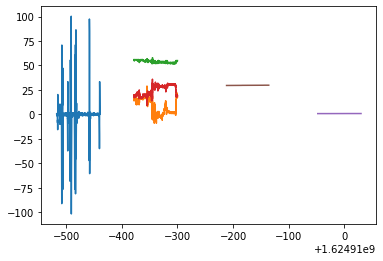

In [2]:
## This code chunk loads the xdf file created from LSL and plots the time series data ##

import pyxdf
import matplotlib.pyplot as plt
import numpy as np

data, header = pyxdf.load_xdf('sub-P001_ses-S001_task-Default_run-001_eeg.xdf')

for stream in data:
    y = stream['time_series']

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{marker[0]}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()

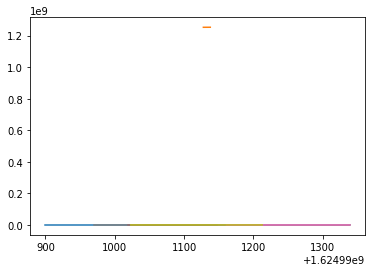

In [3]:
## This code chunk loads the xdf file created from LSL and plots the time series data ##
## Using a different xdf file than the code chunk above ## 

import pyxdf
import matplotlib.pyplot as plt
import numpy as np

data, header = pyxdf.load_xdf('sub-P001_ses-S001_task-Default_run-001_eeg_2.xdf')

for stream in data:
    y = stream['time_series']

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{marker[0]}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()

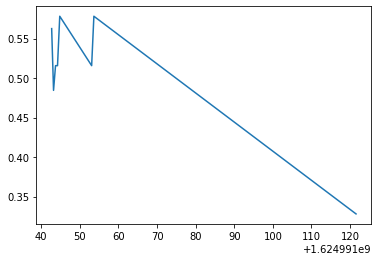

In [15]:
Ibi = data[2]

plt.plot(Ibi['time_stamps'], Ibi['time_series'])

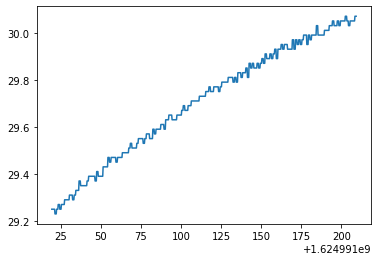

In [17]:
tmp = data[3]
tmp

plt.plot(tmp['time_stamps'], tmp['time_series'])

In [26]:
tag = data[1]

print(tag['time_series'])
#plt.plot(tag['time_stamps'], tag['time_series'])

[[1.252760e+09]
 [1.252936e+09]
 [1.253090e+09]]


In [35]:
for stream in data:
    print(stream['info']['name'])

['bat']
['tag']
['ibi']
['tmp']
['acc']
['gsr']
['bvp']


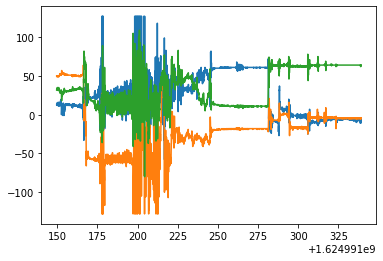

In [39]:
acc = data[4]

plt.plot(acc['time_stamps'], acc['time_series'])

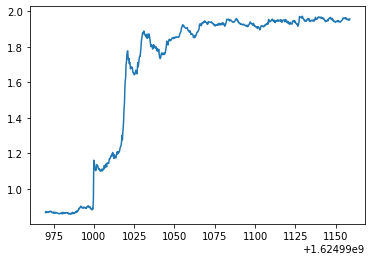

In [41]:
gsr = data[5]

plt.plot(gsr['time_stamps'], gsr['time_series'])

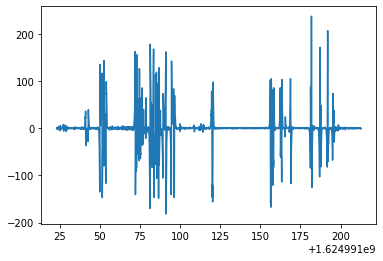

In [36]:
bvp = data[6]
bvp

plt.plot(bvp['time_stamps'], bvp['time_series'])

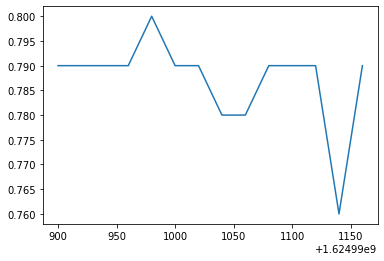

In [43]:
bat = data[0]

plt.plot(bat['time_stamps'], bat['time_series'])

# Most code below this point is Anthony's scratch work exploring the xdf file structure

In [13]:
n = 0
for stream in data:
    n += 1
print(n)

4


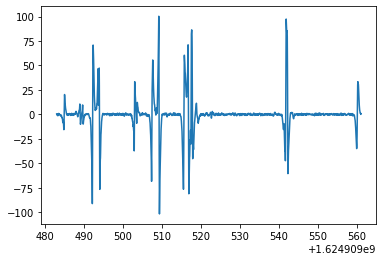

In [33]:
bvp = data[0]
bvp

plt.plot(bvp['time_stamps'], bvp['time_series'])

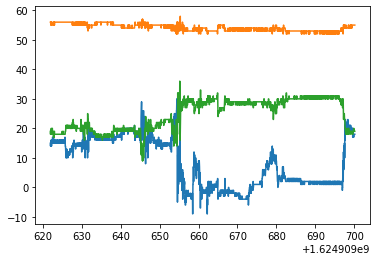

In [37]:
acc = data[1]
acc

plt.plot(acc['time_stamps'], acc['time_series'])

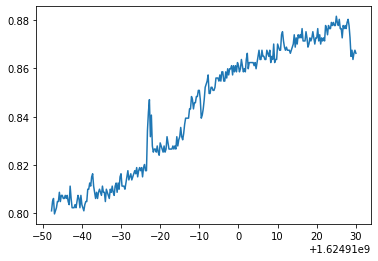

In [41]:
gsr = data[2]
gsr

plt.plot(gsr['time_stamps'], gsr['time_series'])

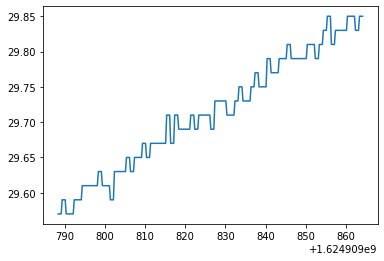

In [44]:
tmp = data[3]
tmp

plt.plot(tmp['time_stamps'], tmp['time_series'])

In [ ]:
data

In [ ]:
for stream in data:
    print(stream)

In [5]:
header

{'info': defaultdict(list,
             {'version': ['1.0'], 'datetime': ['2021-06-28T12:50:31-0700']})}

In [ ]:
data

In [17]:
stream['info']

defaultdict(list,
            {'name': ['tmp'],
             'type': ['Temp'],
             'channel_count': ['1'],
             'channel_format': ['float32'],
             'source_id': ['Temp-empatica_e4'],
             'nominal_srate': ['4.000000000000000'],
             'version': ['1.100000000000000'],
             'created_at': ['61507.42618180000'],
             'uid': ['7be49f66-9a55-4412-ac8c-d66d881302f5'],
             'session_id': ['default'],
             'hostname': ['DESKTOP-UFUU8MC'],
             'v4address': [None],
             'v4data_port': ['16575'],
             'v4service_port': ['16575'],
             'v6address': [None],
             'v6data_port': ['16575'],
             'v6service_port': ['16575'],
             'desc': [None],
             'stream_id': 4,
             'effective_srate': 3.999815497627142})

In [18]:
stream['info']['name']

['tmp']

In [19]:
stream['info']['type']

['Temp']

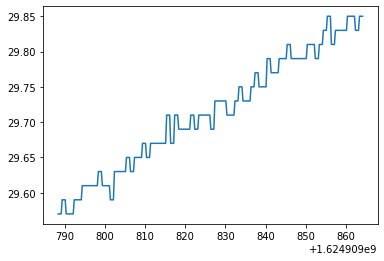

In [21]:
y = stream['time_series']
x = stream['time_stamps']

plt.plot(x, y)

In [23]:
len(stream['time_series'])

304

In [25]:
len(stream['time_stamps'])

304

In [ ]:
data